In [2]:
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from random import random, randint

In [83]:
def fast_confusion_matrix(target, probability, cutoff, len_array = False, sum_target = False):
    if not len_array:
        len_array = len(target)
    if not sum_target:
        sum_target = np.sum(target)
    index = np.count_nonzero(probability >= cutoff)
    if index == 0:
        TP = 0
     else:
        TP = np.sum(target[-index:])
    FN = sum_target - TP
    FP = index - TP
    TN = len_array - sum_target - FP
    return TN, FP, FN, TP


def sort_target_and_prob(target, prob):
    order = np.argsort(prob)
    return target[order], prob[order]


def make_df_cf(list_cut_off, list_tn, list_fp, list_fn, list_tp):
    data_tuples = list(zip(list_cut_off, list_tn, list_fp, list_fn, list_tp))
    df_conf_m = pd.DataFrame(data_tuples, columns=['CUT_OFF', 'TN', 'FP', 'FN', 'TP'])
    del data_tuples
    df_conf_m['accuracy'] = (df_conf_m.TP + df_conf_m.TN) / \
        (df_conf_m.TP + df_conf_m.TN + df_conf_m.FP + df_conf_m.FN)
    df_conf_m['precision'] = df_conf_m.TP / (df_conf_m.TP + df_conf_m.FP)
    df_conf_m['recall'] = df_conf_m.TP / (df_conf_m.TP + df_conf_m.FN)
    df_conf_m['fpr'] = df_conf_m.FP / (df_conf_m.FP + df_conf_m.TN)
    df_conf_m['trp'] = df_conf_m.recall
    df_conf_m['G_means'] = np.sqrt(df_conf_m.trp * (1-df_conf_m.fpr))
    
    return df_conf_m


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
   
    tn, fp, fn, tp = cf.ravel()
    cf = np.array([[tp, fp], [fn, tn]])
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    if sum_stats:
        accuracy  = np.trace(cf) / float(np.sum(cf))

        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    if figsize==None:
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        categories=False

    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)


def gini(auc):
    return 2*auc-1
        
        
def fast_analize_roc_conf_m(df, name_gen_score, name_col_risk_score = False, l_cut_off = False):
    NAME_GEN_SCORE = name_gen_score
    
    if not name_col_risk_score:
        name_col_risk_score = 'prob'
    
    if not l_cut_off:
        l_cut_off = [x/1000 for x in range(1, 1000, 1)]

    array_target_sort, array_score_rsa_sort = sort_target_and_prob(df['target'].to_numpy(), df[name_col_risk_score].to_numpy())
    print('sort: Done!')

    len_t = len(array_target_sort)
    sum_t = np.sum(array_target_sort)


    print(f'target:\n '
          f'sum - {sum_t}\n '
          f'example - {array_target_sort[0]}\n '
          f'type - {type(array_target_sort)}\n '
          f'shape - {array_target_sort.shape}\n')
    print(f'prob:\n '
          f'example - {array_score_rsa_sort[0]}\n ' 
          f'type - {type(array_score_rsa_sort)}\n '
          f'shape - {array_score_rsa_sort.shape}\n')

    print('List cut_off:', ', '.join(map(str, l_cut_off[:12])), '...\n len -', len(l_cut_off), '\n')

    l_tn, l_fp, l_fn, l_tp = [],[],[],[]

    for cutoff in l_cut_off:
        tn, fp, fn, tp = fast_confusion_matrix(array_target_sort, array_score_rsa_sort, cutoff, len_t, sum_t)
        l_tn.append(tn)
        l_fp.append(fp)
        l_fn.append(fn)
        l_tp.append(tp)

    df_conf_m = make_df_cf(l_cut_off,l_tn, l_fp, l_fn, l_tp)

    print(df_conf_m[df_conf_m.G_means == max(df_conf_m.G_means)])

    # plot ROC
    index_G_means_max = np.argmax(df_conf_m['G_means'].to_numpy())
    trp_array = df_conf_m['trp'].to_numpy()
    fpr_array = df_conf_m['fpr'].to_numpy()
    plt.plot(fpr_array, trp_array, label='RUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.scatter(fpr_array[index_G_means_max], trp_array[index_G_means_max]
                , marker='o', color='black', label='Best CutOFF')
    plt.legend()
    # del trp_array, fpr_array

    # plot pretty Confusion Matrix
    cf_row = df_conf_m[df_conf_m.G_means == max(df_conf_m.G_means)][['TN','FP','FN','TP']].values.tolist()[0]
    labels = ['TP', 'FP', 'FN','TN']
    categ = ['Froud', 'Not Froud']
    cut_off = df_conf_m.loc[index_G_means_max]['CUT_OFF']
    make_confusion_matrix(np.array([cf_row[:2],cf_row[2:]]), group_names = labels, categories = categ
                          , title = f'Confusion_matrix: {NAME_GEN_SCORE}\n(cutoff {cut_off})')
    plt.show()
    
    print('AUC:', auc(y=trp_array, x=fpr_array))
    print('GINI:', gini(auc(y=trp_array, x=fpr_array)))
    
    return trp_array, fpr_array, index_G_means_max        

In [84]:
# df.read_csv('data.csv')
df = pd.DataFrame([random() for x in range(10000000)], columns=['prob'])
df['target'] = [randint(0,1) for x in range(10000000)] 

if len(df) == 0:
    print('ERROR df is null')

df.head(5)

,prob,target
0,0.231398,1
1,0.595780,1
2,0.583519,1
3,0.748272,0
4,0.046038,1


sort: Done!
target:
 sum - 4999747
 example - 0
 type - <class 'numpy.ndarray'>
 shape - (10000000,)

prob:
 example - 1.1198367178000268e-07
 type - <class 'numpy.ndarray'>
 shape - (10000000,)

List cut_off: 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012 ...
 len - 999 

     CUT_OFF       TN       FP       FN       TP  accuracy  precision  \
496    0.497  2485005  2515248  2483286  2516461  0.500147   0.500121   

       recall       fpr       trp   G_means  
496  0.503318  0.503024  0.503318  0.500137  


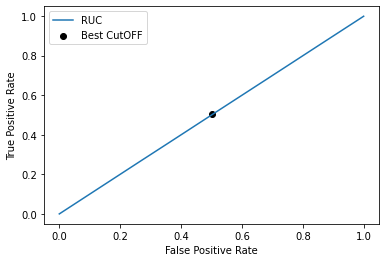

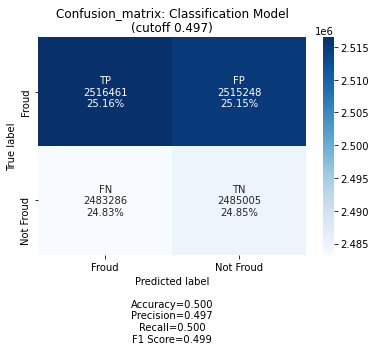

AUC: 0.49909383424167986
GINI: -0.0018123315166402865


In [85]:
trp_array, fpr_array, index_G_means_max = fast_analize_roc_conf_m(df, 'Classification Model', 'prob')